In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import umap.umap_ as umap
from scipy.spatial.distance import squareform, pdist

import osmnx
import matplotlib.cm as cm
import matplotlib as mpl

from local_SE import *

/home/hs17630/anaconda3/envs/local_embedding/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Uncomment the following lines to use a different place name or distance

place_name = "Bristol, UK"
graph = osmnx.graph_from_address(place_name, dist=1000)

# place_name = "Westminster, London, UK"
# graph = osmnx.graph_from_address(place_name, dist=1500)


In [3]:
A_road_nx = nx.adjacency_matrix(graph)
A_road = sparse.csr_matrix(A_road_nx).astype('f')

# make the graph undirected
A_road = A_road + A_road.T
A_road = A_road.sign()

In [4]:
A_road.shape

(4110, 4110)

In [5]:
nodes = osmnx.graph_to_gdfs(graph, edges=False)
nodes = nodes.reset_index()

edges = osmnx.graph_to_gdfs(graph, nodes=False)
edges = edges.reset_index()

In [6]:
ASE_road_3 = sparse_SE(A_road, 3)

In [7]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, min_dist=1, metric='euclidean')
UMAP_ASE_road_3 = reducer.fit_transform(ASE_road_3)

/home/hs17630/anaconda3/envs/local_embedding/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
ASE_road_20 = sparse_SE(A_road, 20)

In [9]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, min_dist=1, metric='euclidean')
UMAP_ASE_road_20 = reducer.fit_transform(ASE_road_20)

/home/hs17630/anaconda3/envs/local_embedding/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
subgraph_indices_road = []

potential_nodes = nodes['osmid']
while len(potential_nodes) > 0:
    node_id = np.random.choice(potential_nodes)
    subgraph = nx.ego_graph(graph, node_id, radius=10)
    subgraph_nodes = list(subgraph.nodes())
    subgraph_indices_road.append(subgraph_nodes)
    potential_nodes = [n for n in potential_nodes if n not in subgraph_nodes]

subgraph_indices_road = [nodes[nodes['osmid'].isin(subgraph)].index.values for subgraph in subgraph_indices_road]    

subgraph_sizes = [len(subgraph) for subgraph in subgraph_indices_road]
#remove any subgraphs with less than 5 nodes
subgraph_indices_road = [subgraph for subgraph, size in zip(subgraph_indices_road, subgraph_sizes) if size >= 5]


In [11]:
len(subgraph_indices_road)

113

In [12]:
LASE_d = 3
full_d_matrix_road = np.zeros((A_road.shape[0], A_road.shape[0]))
d_count_road = np.zeros((A_road.shape[0], A_road.shape[0]))

finite_value_road = None  

for i in range(len(subgraph_indices_road)):
    subgraph_idx = subgraph_indices_road[i]
    subgraph = A_road[subgraph_idx][:, subgraph_idx]
    subgraph_embedding = sparse_SE(subgraph, LASE_d)

    dists = squareform(pdist(subgraph_embedding))

    full_d_matrix_road[np.ix_(subgraph_idx, subgraph_idx)] += dists
    d_count_road[np.ix_(subgraph_idx, subgraph_idx)] += 1

    max_dist = np.max(dists[np.isfinite(dists)])
    if finite_value_road is None or max_dist > finite_value_road:
        finite_value_road = max_dist * 10

d_count_road[d_count_road == 0] = 1
full_d_matrix_road /= d_count_road

full_d_matrix_road[full_d_matrix_road == 0] = finite_value_road
np.fill_diagonal(full_d_matrix_road, 0)

In [13]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, min_dist=1, metric='precomputed')
UMAP_LASE_road_3 = reducer.fit_transform(full_d_matrix_road)

/home/hs17630/anaconda3/envs/local_embedding/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hs17630/anaconda3/envs/local_embedding/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [264]:
# # save the embedding
# np.save('UMAP_LASE_London.npy', UMAP_LASE_road_3)

In [354]:
# # rotate by theta degrees if needed

# theta = np.radians(90)
# rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
#                              [np.sin(theta), np.cos(theta)]])
# UMAP_LASE_road_3 = UMAP_LASE_road_3 @ rotation_matrix

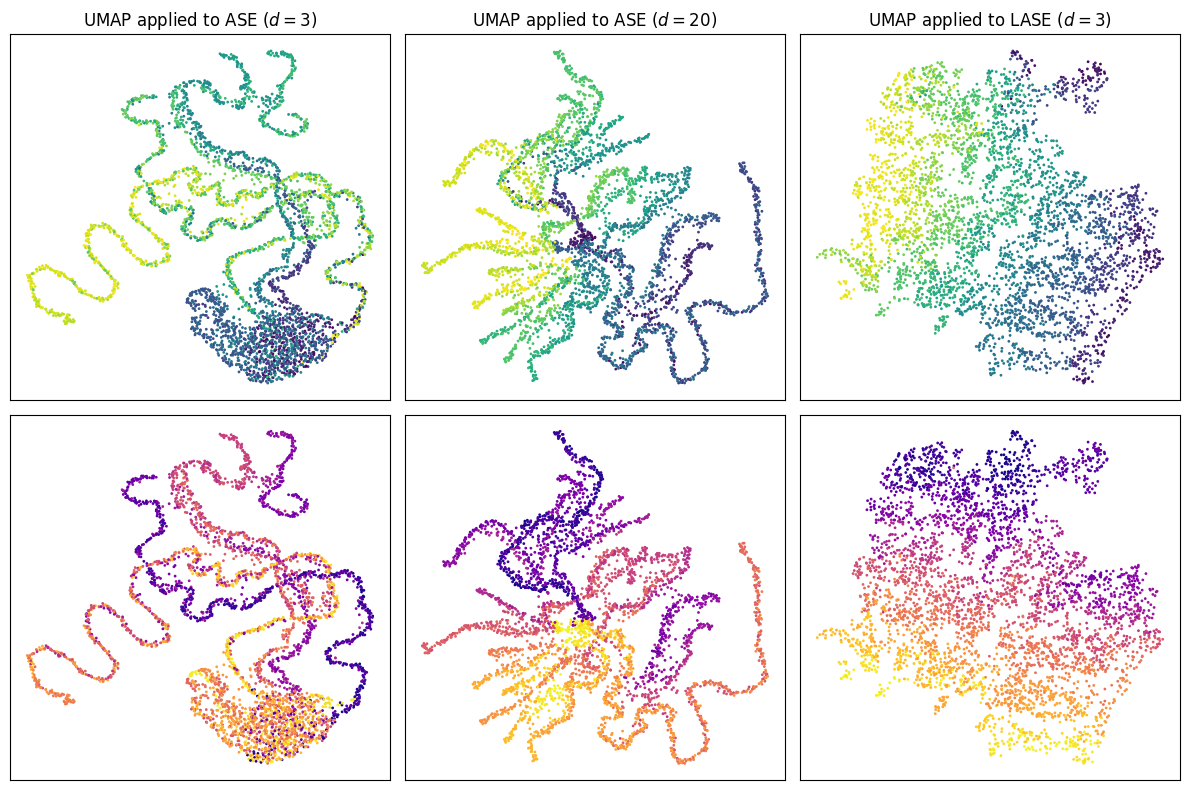

In [ ]:

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.scatter(UMAP_ASE_road_3[:, 0], -UMAP_ASE_road_3[:, 1], s=1, c=nodes['x'], cmap='viridis')
plt.title(r'UMAP applied to ASE ($d=3$)')
plt.xticks([])
plt.yticks([])

plt.subplot(234)
plt.scatter(UMAP_ASE_road_3[:, 0], -UMAP_ASE_road_3[:, 1], s=1, c=nodes['y'], cmap='plasma')
plt.xticks([])
plt.yticks([])

plt.subplot(232)
plt.scatter(-UMAP_ASE_road_20[:, 0], -UMAP_ASE_road_20[:, 1], s=1, c=nodes['x'], cmap='viridis')
plt.title(r'UMAP applied to ASE ($d=20$)')
plt.xticks([])
plt.yticks([])

plt.subplot(235)
plt.scatter(-UMAP_ASE_road_20[:, 0], -UMAP_ASE_road_20[:, 1], s=1, c=nodes['y'], cmap='plasma')
plt.xticks([])
plt.yticks([])

plt.subplot(233)
plt.scatter(UMAP_LASE_road_3[:, 1], -UMAP_LASE_road_3[:, 0], s=1, c=nodes['x'], cmap='viridis')
plt.title(r'UMAP applied to LASE ($d=3$)')
plt.xticks([])
plt.yticks([])

plt.subplot(236)    
plt.scatter(UMAP_LASE_road_3[:, 1], -UMAP_LASE_road_3[:, 0], s=1, c=nodes['y'], cmap='plasma')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

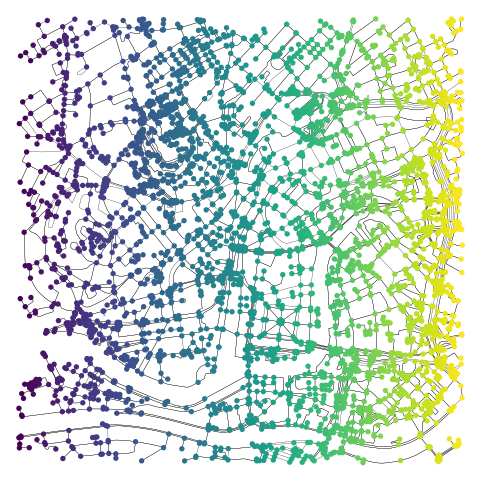

In [15]:
# plot the true road network
fig, ax = plt.subplots(figsize=(6, 6))
osmnx.plot_graph(graph, ax=ax, node_size=15, node_color=nodes['x'], edge_color='black', edge_linewidth=0.2)
plt.show()

/tmp/ipykernel_14902/3032716442.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('plasma')


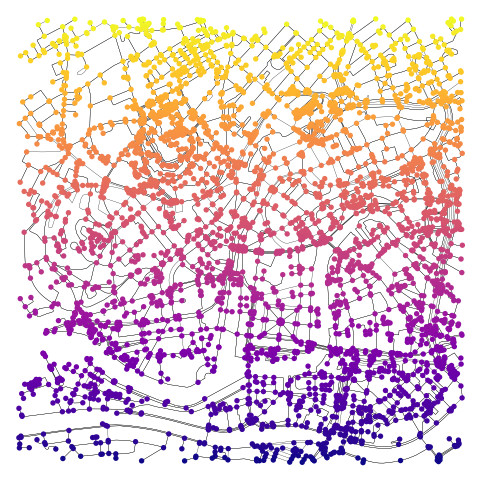

In [16]:
cmap = mpl.cm.get_cmap('plasma')
norm = mpl.colors.Normalize(vmin=min(nodes['y']), vmax=max(nodes['y']))
m = cm.ScalarMappable(norm=norm, cmap=cmap)


fig, ax = plt.subplots(figsize=(6, 6))
osmnx.plot_graph(graph, ax=ax, node_size=15, node_color=m.to_rgba(nodes['y']), edge_color='black', edge_linewidth=0.2)
plt.show()

In [20]:
# Define locations of interest in Bristol

x_bearpit = -2.59075
y_bearpit = 51.45944
radius = 0.003
bearpit_nodes = nodes[(nodes['x'] - x_bearpit)**2 + (nodes['y'] - y_bearpit)**2 < radius**2]
bearpit_indices = bearpit_nodes.index.values

x_uni = -2.6023
y_uni = 51.458
uni_nodes =  nodes[(nodes['x'] - x_uni)**2 + (nodes['y'] - y_uni)**2 < radius**2]

x_redcliffe = -2.589
y_redcliffe = 51.4476
redcliffe_nodes = nodes[(nodes['x'] - x_redcliffe)**2 + (nodes['y'] - y_redcliffe)**2 < radius**2]

x_center = -2.598
y_center = 51.452
center_nodes = nodes[(nodes['x'] - x_center)**2 + (nodes['y'] - y_center)**2 < radius**2]

radius=0.004
x_river = -2.608
y_river = 51.4493
river_nodes_bris = nodes[(nodes['x'] - x_river)**2 + (nodes['y'] - y_river)**2 < radius**2]


In [21]:
# Define locations of interest in London

river_nodes = nodes[((nodes['x'] > -0.126) & (nodes['x'] < -0.117) & (nodes['y'] < 51.507)) | 
                    ((nodes['x'] > -0.126) & (nodes['y'] < 51.513) & (nodes['y'] > 51.506)) | 
                    ((nodes['x'] > -0.131) & (nodes['x'] < -0.125) & (nodes['y'] < 51.491))]
river_indices = river_nodes.index.values

x_waterloo = -0.1128
y_waterloo = 51.5035
radius = 0.004
waterloo_nodes = nodes[(nodes['x'] - x_waterloo)**2 + (nodes['y'] - y_waterloo)**2 < radius**2]

x_soho = -0.1281
y_soho = 51.5081
radius = 0.004
soho_nodes = nodes[(nodes['x'] - x_soho)**2 + (nodes['y'] - y_soho)**2 < radius**2]

x_westminster = -0.1346
y_westminster = 51.4976
radius = 0.004
westminster_nodes = nodes[(nodes['x'] - x_westminster)**2 + (nodes['y'] - y_westminster)**2 < radius**2]

x_vauxhall = -0.117
y_vauxhall = 51.490
radius = 0.004
vauxhall_nodes = nodes[(nodes['x'] - x_vauxhall)**2 + (nodes['y'] - y_vauxhall)**2 < radius**2]

/tmp/ipykernel_14902/847966078.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab10')


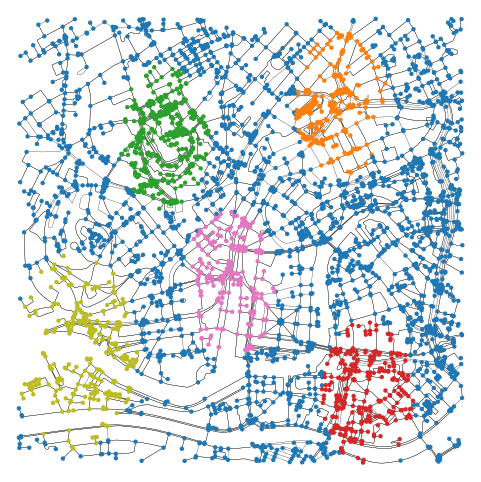

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [22]:
colors = np.zeros(len(nodes), dtype=int)

### Uncomment the following for the Bristol road network ###
colors[bearpit_indices] = 1
colors[uni_nodes.index.values] = 2
colors[redcliffe_nodes.index.values] = 3
colors[center_nodes.index.values] = 6
colors[river_nodes_bris.index.values] = 8


### Uncomment the following for the London road network ###
# colors[river_indices] = 1
# colors[waterloo_nodes.index.values] = 2
# colors[soho_nodes.index.values] = 3
# colors[westminster_nodes.index.values] = 6
# colors[vauxhall_nodes.index.values] = 8

cmap = mpl.cm.get_cmap('tab10')


fig, ax = plt.subplots(figsize=(6, 6))
osmnx.plot_graph(graph, ax=ax, node_size=10, node_color=cmap(colors), edge_color='black', edge_linewidth=0.2)

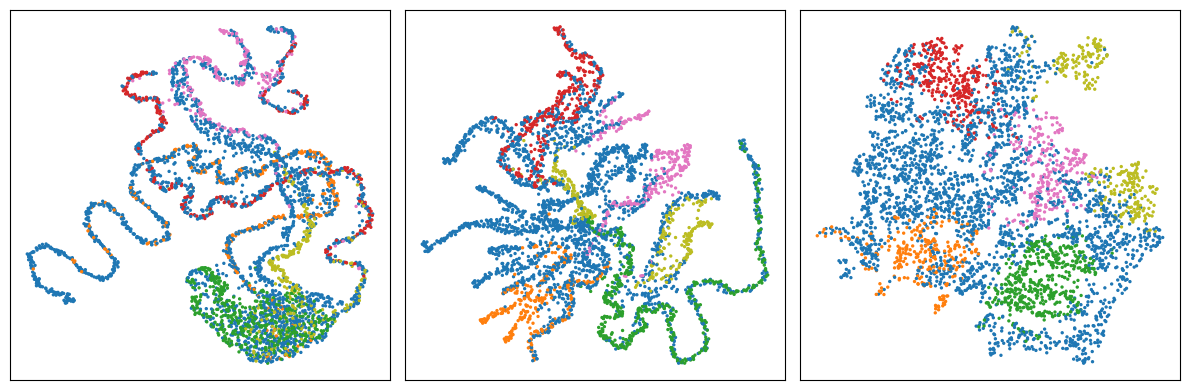

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(UMAP_ASE_road_3[:, 0], -UMAP_ASE_road_3[:, 1], s=2,c=cmap(colors))
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.scatter(-UMAP_ASE_road_20[:, 0], -UMAP_ASE_road_20[:, 1], s=2, c=cmap(colors))
plt.xticks([])  
plt.yticks([])

plt.subplot(133)
plt.scatter(UMAP_LASE_road_3[:, 1], -UMAP_LASE_road_3[:, 0], s=2, c=cmap(colors))
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Node2Vec

In [24]:
from node2vec import Node2Vec
import networkx as nx

graph_nx = nx.from_scipy_sparse_array(A_road)


node2vec = Node2Vec(graph_nx, dimensions=3, walk_length=30, num_walks=50, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = model.wv
node_embeddings = np.array([embeddings[str(node)] for node in range(A_road.shape[0])])

Generating walks (CPU: 4): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


In [23]:
# #save the embeddings

# np.save('umap_nod2vec_bristol.npy', node_embeddings)
# # np.save('umap_nod2vec_london.npy', node_embeddings_3)

In [25]:
# Perform UMAP on node embeddings
reducer = umap.UMAP(n_components=2, n_neighbors=25, min_dist=1, metric='euclidean')
UMAP_node2vec = reducer.fit_transform(node_embeddings)

/home/hs17630/anaconda3/envs/local_embedding/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/tmp/ipykernel_14902/2998288329.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('tab10')


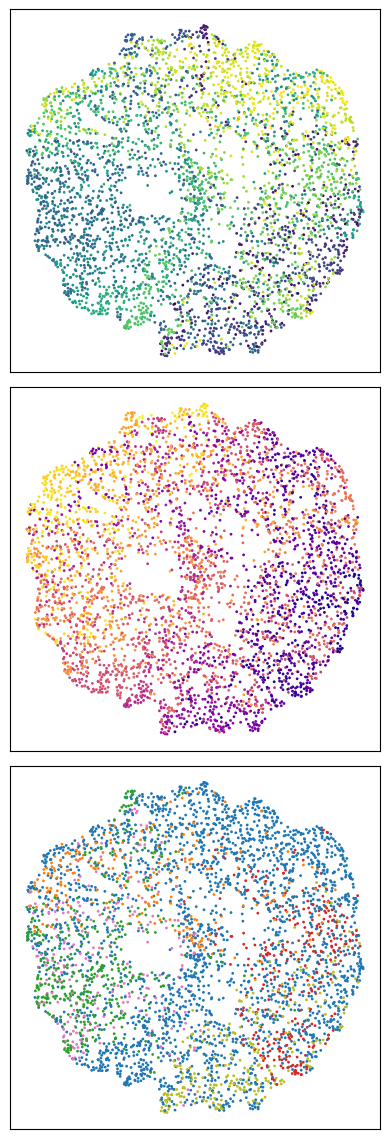

In [27]:
plt.figure(figsize=(4, 11.5))

plt.subplot(311 )

plt.scatter(-UMAP_node2vec[:, 0], -UMAP_node2vec[:, 1], s=1, c=nodes['x'], cmap='viridis')
plt.xticks([])
plt.yticks([])

plt.subplot(312)
plt.scatter(-UMAP_node2vec[:, 0], -UMAP_node2vec[:, 1], s=1, c=nodes['y'], cmap='plasma')
plt.xticks([])
plt.yticks([])

plt.subplot(313)
cmap = mpl.cm.get_cmap('tab10')
plt.scatter(-UMAP_node2vec[:, 0], -UMAP_node2vec[:, 1], s=1, c=cmap(colors))
plt.xticks([])
plt.yticks([])

plt.tight_layout()